## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_long as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 1
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**0
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
    ,dataDir = 'data'
    ,num_workers=16
)

sg.DCfg = sg.DCfgClass(2, sinoLen=32*5)

os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, exclusive=False)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive=True)

['data/18692a.ExpChicken6mGyShift', 'data/23574.8965435L.Eiger.32kev_sft', 'data/19022g.11-EggLard', 'data/18692b.MinceO', 'data/23574.8965435L.Eiger.32kev_org', 'data/19736b.09_Feb.4176862R_Eig_Threshold-4keV', 'data/20982b.04_774784R', 'data/18515.Lamb1_Eiger_7m_45keV_360Scan', 'data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', 'data/18692b_input_PhantomM', 'data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz', 'data/23574h.9230799R.35kev', 'data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1', 'data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2', 'data/19932.10_8093920_35keV', 'data/19932.14_2442231_23keV', 'data/19932.16_4193759_60keV']
Loading train set 1 of 17: data/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: 

### <font style="color:lightblue">Show</font>

(2, 278, 464) 26262 (7401, 80)
-3.889e-01, 8.807e-03, -4.164e-01, -3.658e-01


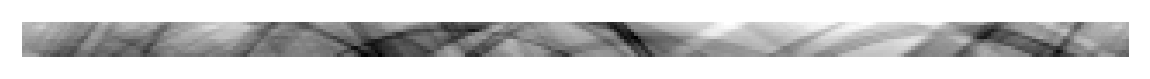

In [ ]:
sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 2)
sg.showMe(sg.testSet)
#sg.showMe(sg.testSet,  26262 )


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.amplitude = 1
        self.baseChannels = 32

        self.encoders =  nn.ModuleList([
            self.encblock( 1, 1, 3, padding=1, norm=False),
            self.encblock( 1, 2, 3, padding=0),
            self.encblock( 2, 4, 3, padding=0),
            self.encblock( 4, 8, 3, padding=0),
            ])

        self.fcLink = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (256, 4, 4)),
        )
        sg.fillWheights(self.fcLink)

        self.decoders = nn.ModuleList([
            self.decblock( 16, 4, 3, padding=0),
            self.decblock(  8, 2, 3, padding=0),
            self.decblock(  4, 1, 3, padding=0),
            self.decblock(  2, 1, 3, padding=1, norm=False),
            ])
        self.lastTouch = nn.Sequential(
            nn.Conv2d(64, 32, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone().detach()
        with torch.no_grad() :
            modelIn[self.gapRng] = self.preProc(images)
            modelIn = modelIn.view( images.shape[0] , self.baseChannels, 10, images.shape[-1] )

        #return squeezeOrg(modelIn[self.gapRng], orgDims)
        if self.latentChannels :
            latent = self.noise2latent(noises)
            dwTrain = [torch.cat((modelIn, latent), dim=1),]
        else :
            dwTrain = [modelIn,]

        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        #return mid
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn ), dim=1 ))
        #return res

        patches = modelIn[self.gapRng] + res[self.gapRng] * self.amplitude
        patches = patches.view(images.shape[0] , 1, images.shape[2], self.gapW)
        return sg.squeezeOrg(patches, orgDims)





generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
#generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2



### <font style="color:lightblue">Generator</font>

In [7]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(sg.refImages.shape, sg.refImages[[0],...].shape)
print(model_summary)


torch.Size([4, 1, 320, 10]) torch.Size([1, 1, 320, 10])
Layer (type:depth-idx)                   Output Shape              Param #
Generator2                               [1, 1, 320, 2]            --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 32, 10, 10]           --
│    │    └─Conv2d: 3-1                  [1, 32, 10, 10]           9,248
│    │    └─LeakyReLU: 3-2               [1, 32, 10, 10]           --
│    └─Sequential: 2-2                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             18,496
│    │    └─LeakyReLU: 3-4               [1, 64, 8, 8]             --
│    └─Sequential: 2-3                   [1, 128, 6, 6]            --
│    │    └─Conv2d: 3-5                  [1, 128, 6, 6]            73,856
│    │    └─LeakyReLU: 3-6               [1, 128, 6, 6]            --
│    └─Sequential: 2-4                   [1, 256, 4, 4]            --
│    │    └─Conv2d

### <font style="color:lightblue">Discriminator</font>

In [8]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.05
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.05


## <font style="color:lightblue">Norms</font>

In [9]:
sg.testLoader = sg.createDataLoader(sg.testSet, shuffle=False)#, num_workers=16)
sg.dataLoader = sg.createDataLoader(sg.trainSet, shuffle=True)#, num_workers=16)

#sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


## <font style="color:lightblue">Restore checkpoint</font>

In [10]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)

sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
#sg.optimizer_G.step()
#sg.optimizer_D.step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


Initial LR : G 1.000e-04 (1.0000)


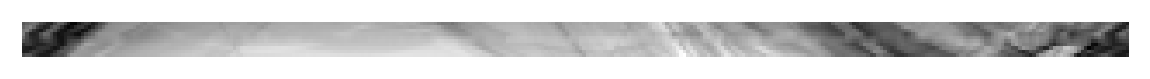

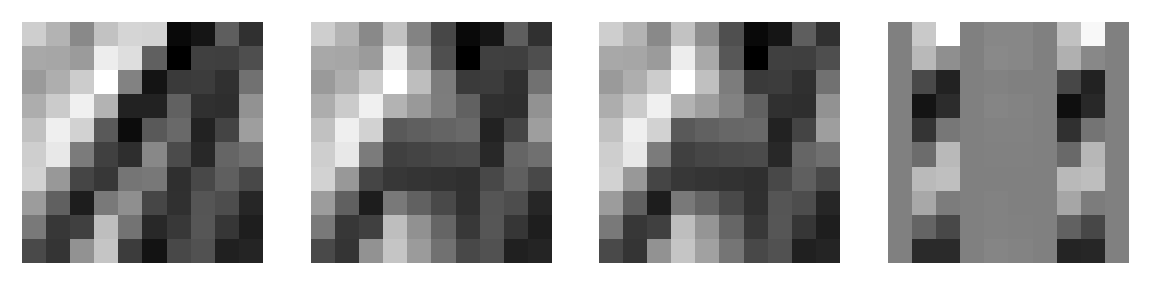

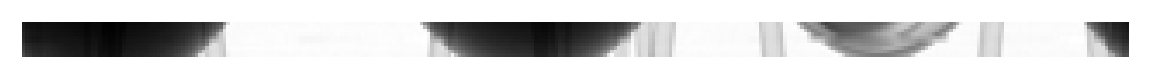

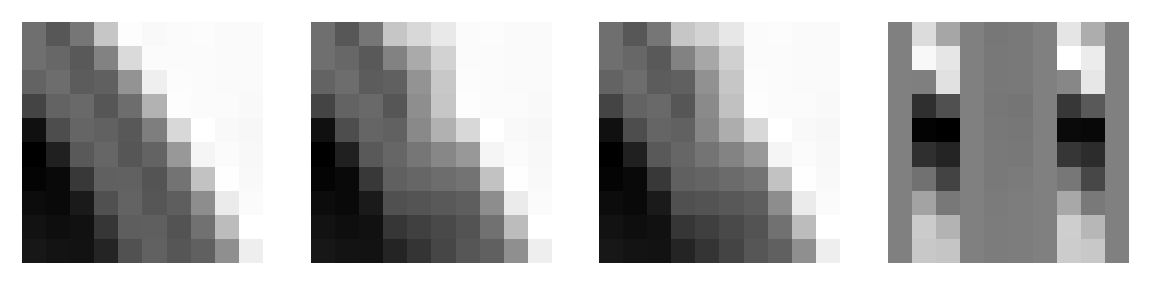

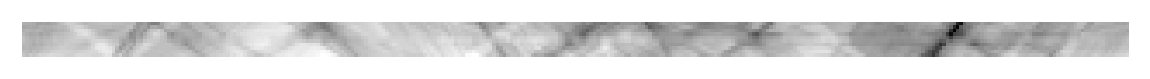

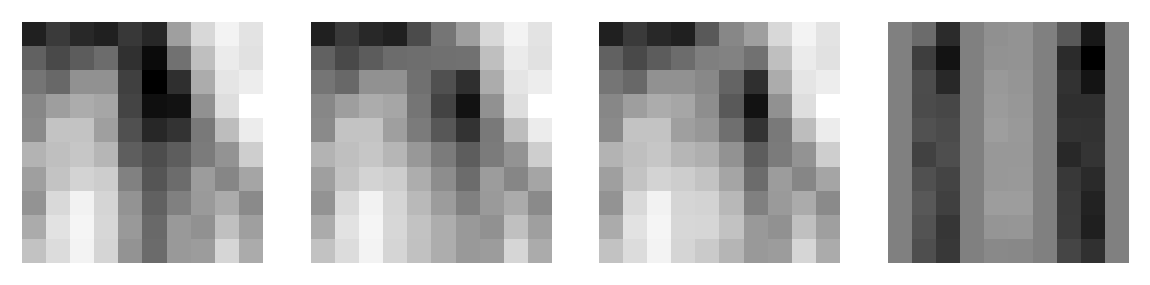

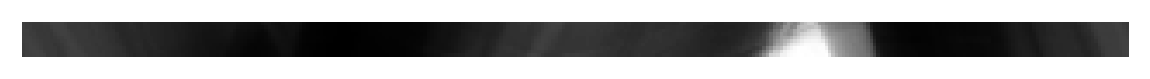

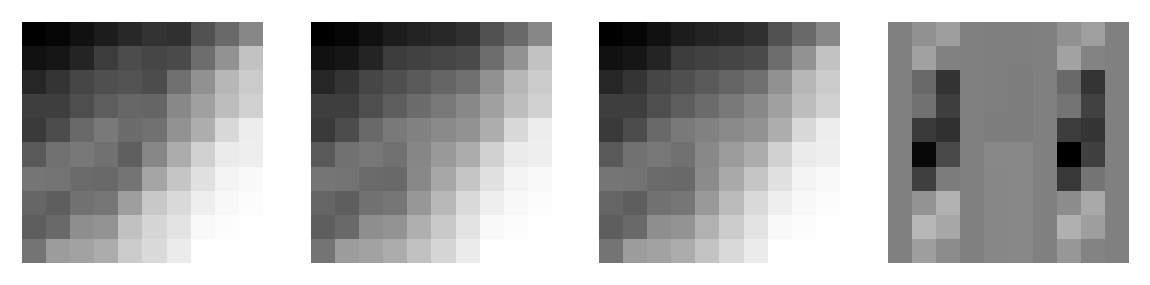

In [11]:
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 3 (2).  Images: 256. DIS: 0.000e+00, GEN: 4.302e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 0.000e+00  MSE: 4.302e+00  L1L: 2.164e+00  SSIM: 1.297e+00  MSSSIM: 1.738e+00 



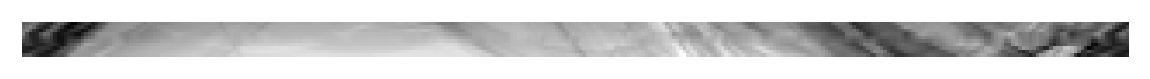

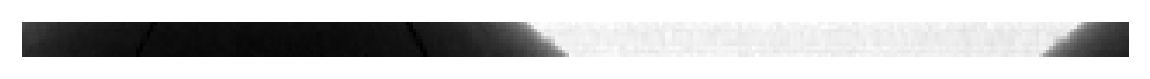

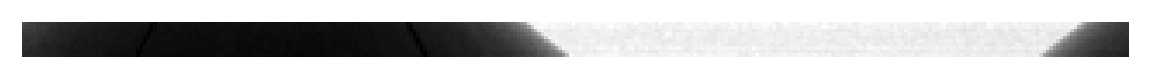

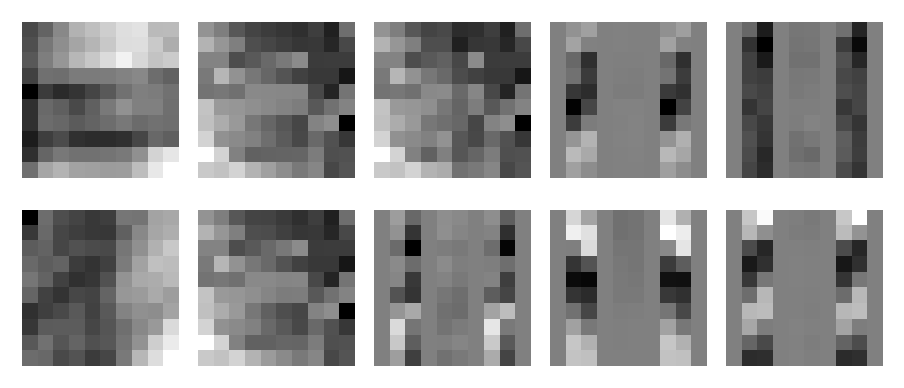

  0%|          | 48/66741 [00:09<3:31:45,  5.25it/s]


KeyboardInterrupt: 

In [13]:



def my_beforeReport(sglocals) :
    message = ""
    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.1)
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(message + "\n")
    print(message)
    return
#sg.beforeReport = my_beforeReport


#sg.TCfg.num_workers=0
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise

#BS=2**8, LR=1e-4, saw

## <font style="color:lightblue">Post</font>

In [12]:
resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   ,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
sg.writer.add_scalars("Metrices test", resTest.metrices, sg.epoch )
sg.writer.add_scalars("Probs test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )



100%|██████████| 194/194 [00:04<00:00, 40.17it/s]

Images: 49664. DIS: 0.000e+00, GEN: 1.070e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 0.000e+00  MSE: 1.070e+00  L1L: 1.407e+00  SSIM: 3.281e+00  MSSSIM: 2.593e+00 



In [18]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)

### <font style="color:lightblue">Save results</font>

In [12]:
sg.epoch

1